In [79]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_6f4fd04a0ef7434fa706855c99bfc6e2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='IxauJRbftIB3kUhumujiuhBdcb8qNnxg-fCWA1HfUE3Q',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_6f4fd04a0ef7434fa706855c99bfc6e2.get_object(Bucket='windturbinenew-donotdelete-pr-67r16kz5fl16dd',Key='Book1.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_excel(body)
data.head()


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [80]:
import pandas as pd          
import numpy as np          
import matplotlib.pyplot as plt  
from datetime import datetime    
from pandas import Series        
%matplotlib inline 
import warnings   

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [81]:
data.shape

(50530, 5)

In [82]:
data.isnull().values.any()

False

In [83]:
data.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1483.884542,7.559358,1655.310239,123.796968
std,1173.106819,4.225833,1237.554709,93.341947
min,0.000200,0.205178,16.021926,0.015678
25%,675.458801,4.203546,659.583322,49.513701
50%,825.871515,7.104688,1063.841645,73.713036
75%,2482.507569,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [84]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(data,test_size=0.3,shuffle=False)

In [85]:
train.shape,test.shape


((35371, 5), (15159, 5))

In [86]:
train_original=train.copy() 
test_original=test.copy()
train.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [87]:
train['Date/Time'] = pd.to_datetime(train['Date/Time'],format='%d %m %Y %H:%M') 
test['Date/Time'] = pd.to_datetime(test['Date/Time'],format='%d %m %Y %H:%M')
test_original['Date/Time'] = pd.to_datetime(test_original['Date/Time'],format='%d %m %Y %H:%M')
train_original['Date/Time'] = pd.to_datetime(train_original['Date/Time'],format='%d %m %Y %H:%M')


In [88]:
for i in (train, test, test_original, train_original):
    i['year']=i['Date/Time'].dt.year 
    i['month']=i['Date/Time'].dt.month 
    i['day']=i['Date/Time'].dt.day
    i['Hour']=i['Date/Time'].dt.hour 

In [89]:
train.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),year,month,day,Hour
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087,2018,1,1,0
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0


In [90]:
test.tail()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),year,month,day,Hour
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23
50529,2018-12-31 23:50:00,2820.466064,9.979332,2779.184096,82.274620,2018,12,31,23


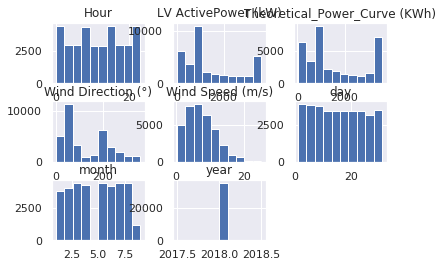

In [91]:
series = train
series.hist()
plt.show()

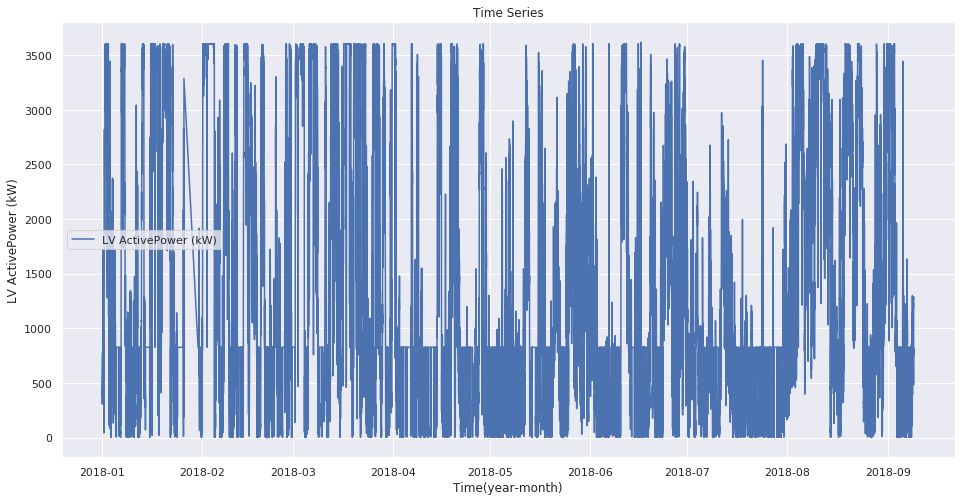

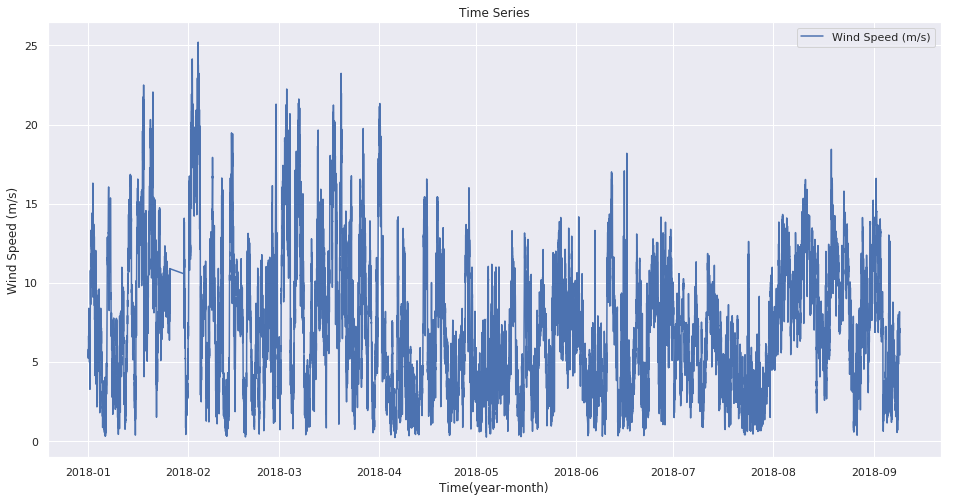

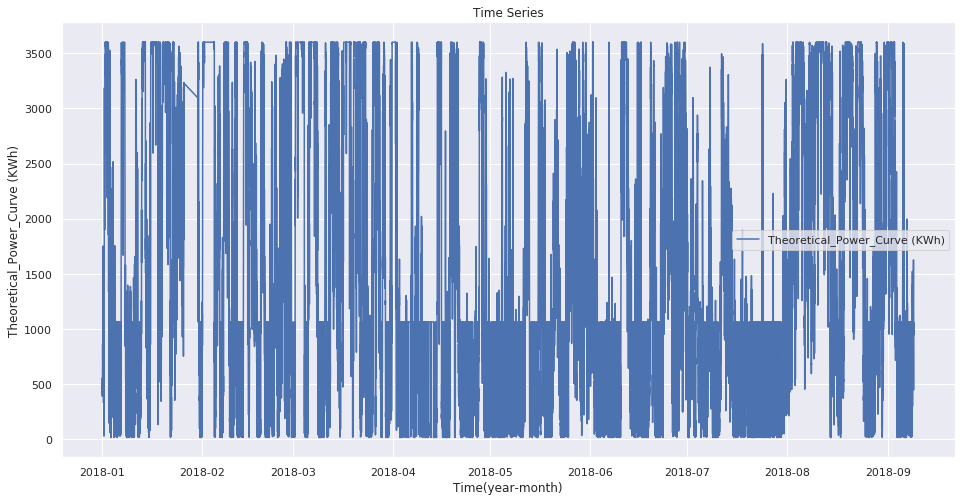

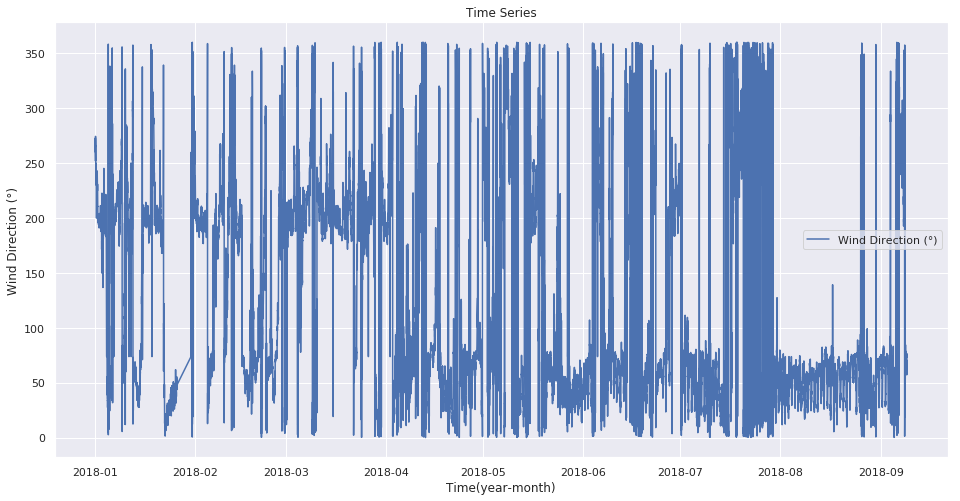

In [92]:
from pandas.plotting import register_matplotlib_converters 
train.index = train['Date/Time'] # indexing the Datetime to get the time period on the x-axis. 
ts = train['LV ActivePower (kW)'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='LV ActivePower (kW)') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("LV ActivePower (kW)") 
plt.legend(loc='best')

ts = train['Wind Speed (m/s)'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Wind Speed (m/s)') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Wind Speed (m/s)") 
plt.legend(loc='best')

ts = train['Theoretical_Power_Curve (KWh)'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Theoretical_Power_Curve (KWh)') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Theoretical_Power_Curve (KWh)") 
plt.legend(loc='best')

ts = train['Wind Direction (°)'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Wind Direction (°)') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Wind Direction (°)") 
plt.legend(loc='best')

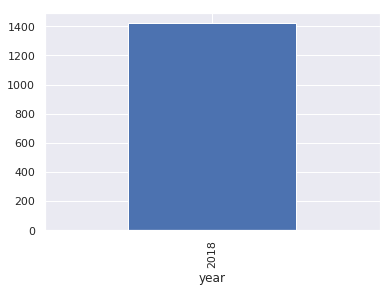

In [93]:
train.groupby('year')['LV ActivePower (kW)'].mean().plot.bar()

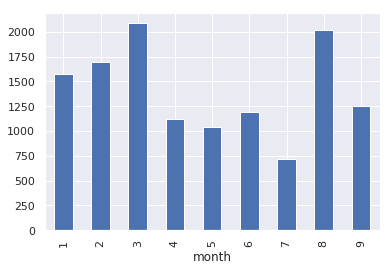

In [94]:
train.groupby('month')['LV ActivePower (kW)'].mean().plot.bar()

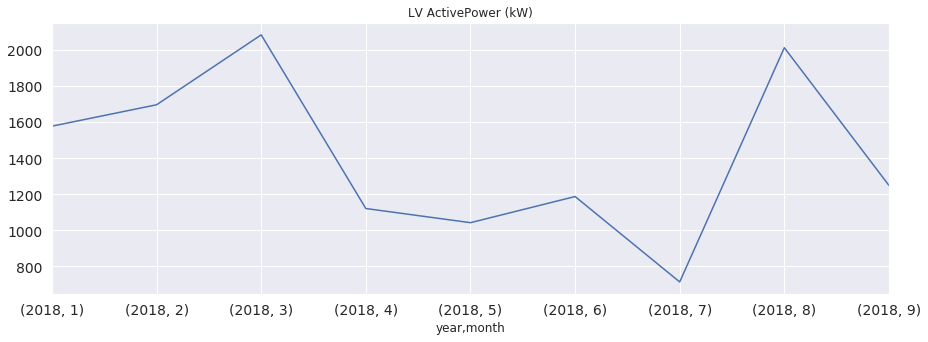

In [95]:
temp=train.groupby(['year', 'month'])['LV ActivePower (kW)'].mean() 
temp.plot(figsize=(15,5), title= 'LV ActivePower (kW)', fontsize=14)

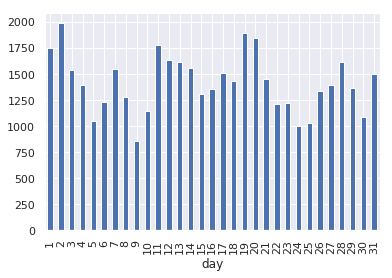

In [96]:
train.groupby('day')['LV ActivePower (kW)'].mean().plot.bar()

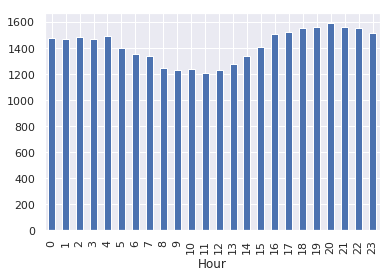

In [97]:
train.groupby('Hour')['LV ActivePower (kW)'].mean().plot.bar()

In [98]:
train.Timestamp = pd.to_datetime(train['Date/Time'],format='%d %m %Y %H:%M') 
train.index = train.Timestamp 
# Hourly time series 
hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

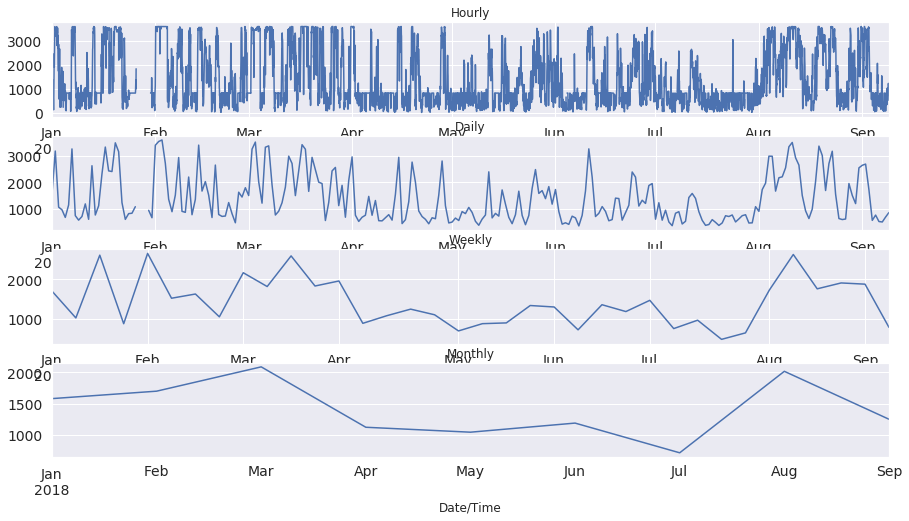

In [99]:
fig, axs = plt.subplots(4,1) 
hourly['LV ActivePower (kW)'].plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily['LV ActivePower (kW)'].plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly['LV ActivePower (kW)'].plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly['LV ActivePower (kW)'].plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.show()

In [100]:
test.Timestamp = pd.to_datetime(test['Date/Time'],format='%d %m %Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean() 

train.Timestamp = pd.to_datetime(train['Date/Time'],format='%d %m %Y %H:%M')
train.index = train.Timestamp 
# Converting to daily mean 
train = train.resample('D').mean()

In [101]:
train

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),year,month,day,Hour
Date/Time,,,,,,,,
2018-01-01,1535.204483,8.022975,1622.990048,229.735242,2018.0,1.0,1.0,11.500000
2018-01-02,3182.564250,12.000548,3314.693471,197.859789,2018.0,1.0,2.0,11.500000
2018-01-03,1057.943702,6.650189,1102.505694,192.476045,2018.0,1.0,3.0,11.500000
2018-01-04,958.037436,6.232531,922.224978,122.459975,2018.0,1.0,4.0,11.598425
2018-01-05,668.541026,3.121434,773.040291,154.906666,2018.0,1.0,5.0,11.500000
2018-01-06,1140.727135,4.090141,1198.626297,183.657854,2018.0,1.0,6.0,11.521429
2018-01-07,3262.830648,12.193147,3366.139098,210.715708,2018.0,1.0,7.0,11.500000
2018-01-08,735.386057,5.677386,806.241550,216.725313,2018.0,1.0,8.0,11.500000
2018-01-09,565.086185,4.725273,507.528264,140.118518,2018.0,1.0,9.0,11.500000


In [102]:
train['LV ActivePower (kW)'] = train['LV ActivePower (kW)'].replace(np.nan,1483.884542 )
train['Wind Speed (m/s)'] = train['Wind Speed (m/s)'].replace(np.nan,7.559358 )
train['Theoretical_Power_Curve (KWh)'] = train['Theoretical_Power_Curve (KWh)'].replace(np.nan,1655.310239 )
train['Wind Direction (°)'] = train['Wind Direction (°)'].replace(np.nan,123.796968 )
train['year'] = train['year'].replace(np.nan,2018)
train['month'] = train['month'].replace(np.nan,1)
train['Hour'] = train['Hour'].replace(np.nan,2.82)
train.loc['2018-01-27', 'day'] = '27'
train.loc['2018-01-28', 'day'] = '28'
train.loc['2018-01-29', 'day'] = '29'
train

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),year,month,day,Hour
Date/Time,,,,,,,,
2018-01-01,1535.204483,8.022975,1622.990048,229.735242,2018.0,1.0,1,11.500000
2018-01-02,3182.564250,12.000548,3314.693471,197.859789,2018.0,1.0,2,11.500000
2018-01-03,1057.943702,6.650189,1102.505694,192.476045,2018.0,1.0,3,11.500000
2018-01-04,958.037436,6.232531,922.224978,122.459975,2018.0,1.0,4,11.598425
2018-01-05,668.541026,3.121434,773.040291,154.906666,2018.0,1.0,5,11.500000
2018-01-06,1140.727135,4.090141,1198.626297,183.657854,2018.0,1.0,6,11.521429
2018-01-07,3262.830648,12.193147,3366.139098,210.715708,2018.0,1.0,7,11.500000
2018-01-08,735.386057,5.677386,806.241550,216.725313,2018.0,1.0,8,11.500000
2018-01-09,565.086185,4.725273,507.528264,140.118518,2018.0,1.0,9,11.500000


In [103]:
test

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),year,month,day,Hour
Date/Time,,,,,,,,
2018-09-09,610.170577,5.979259,758.250947,52.278792,2018.0,9.0,9.0,13.161290
2018-09-10,489.984507,5.319503,578.945818,77.164278,2018.0,9.0,10.0,11.500000
2018-09-11,594.201770,3.981228,754.956061,149.089347,2018.0,9.0,11.0,11.500000
2018-09-12,1167.059666,5.996219,1330.843806,45.443981,2018.0,9.0,12.0,11.500000
2018-09-13,1850.728983,8.718563,1960.015987,93.782751,2018.0,9.0,13.0,11.447552
2018-09-14,988.971655,6.350392,1057.457985,233.371752,2018.0,9.0,14.0,11.255814
2018-09-15,595.722741,3.148160,720.450369,220.821314,2018.0,9.0,15.0,11.500000
2018-09-16,1176.373389,6.289901,1295.768623,123.878516,2018.0,9.0,16.0,11.500000
2018-09-17,2836.835014,11.096484,3004.061383,51.466761,2018.0,9.0,17.0,11.500000


In [104]:
test['LV ActivePower (kW)'] = test['LV ActivePower (kW)'].replace(np.nan,1483.884542 )
test['Wind Speed (m/s)'] = test['Wind Speed (m/s)'].replace(np.nan,7.559358 )
test['Theoretical_Power_Curve (KWh)'] = test['Theoretical_Power_Curve (KWh)'].replace(np.nan,1655.310239 )
test['Wind Direction (°)'] = test['Wind Direction (°)'].replace(np.nan,123.796968 )
test['year'] = test['year'].replace(np.nan,2018)
test['month'] = test['month'].replace(np.nan,1)
test['Hour'] = test['Hour'].replace(np.nan,2.82)
test.loc['2018-09-29', 'day'] = '29'
test.loc['2018-09-30', 'day'] = '30'
test.loc['2018-10-01', 'day'] = '1'
test

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),year,month,day,Hour
Date/Time,,,,,,,,
2018-09-09,610.170577,5.979259,758.250947,52.278792,2018.0,9.0,9,13.161290
2018-09-10,489.984507,5.319503,578.945818,77.164278,2018.0,9.0,10,11.500000
2018-09-11,594.201770,3.981228,754.956061,149.089347,2018.0,9.0,11,11.500000
2018-09-12,1167.059666,5.996219,1330.843806,45.443981,2018.0,9.0,12,11.500000
2018-09-13,1850.728983,8.718563,1960.015987,93.782751,2018.0,9.0,13,11.447552
2018-09-14,988.971655,6.350392,1057.457985,233.371752,2018.0,9.0,14,11.255814
2018-09-15,595.722741,3.148160,720.450369,220.821314,2018.0,9.0,15,11.500000
2018-09-16,1176.373389,6.289901,1295.768623,123.878516,2018.0,9.0,16,11.500000
2018-09-17,2836.835014,11.096484,3004.061383,51.466761,2018.0,9.0,17,11.500000


In [105]:
train.dtypes

LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
year                             float64
month                            float64
day                               object
Hour                             float64
dtype: object

In [106]:
train["day"] = pd.to_numeric(train["day"])
train.dtypes

LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
year                             float64
month                            float64
day                              float64
Hour                             float64
dtype: object

In [107]:
test.dtypes

LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
year                             float64
month                            float64
day                               object
Hour                             float64
dtype: object

In [108]:
test["day"] = pd.to_numeric(test["day"])
test.dtypes

LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
year                             float64
month                            float64
day                              float64
Hour                             float64
dtype: object

In [109]:
Train=train.loc['2018-01-01':'2018-07-09']
valid=train.loc['2018-07-10':'2018-09-09']


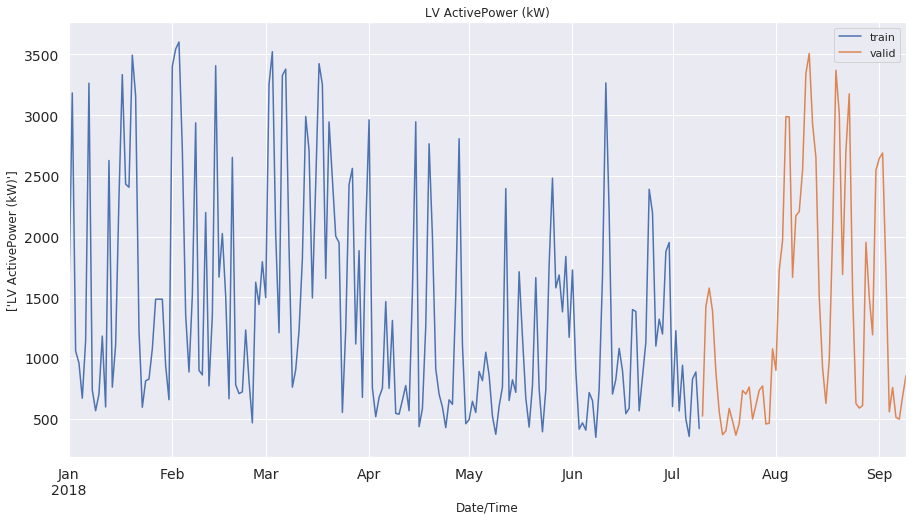

In [110]:
Train['LV ActivePower (kW)'].plot(figsize=(15,8), title= 'LV ActivePower (kW)', fontsize=14, label='train') 
valid['LV ActivePower (kW)'].plot(figsize=(15,8), title= 'LV ActivePower (kW)', fontsize=14, label='valid')
plt.xlabel("Date/Time")
plt.ylabel("['LV ActivePower (kW)']") 
plt.legend(loc='best')
plt.show()

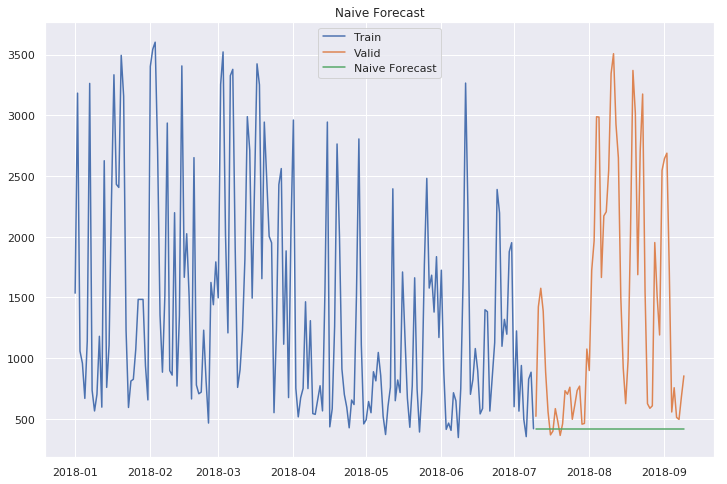

In [111]:
dd= np.asarray(Train['LV ActivePower (kW)']) 
y_hat = valid.copy() 
y_hat['naive'] = dd[len(dd)-1] 
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['LV ActivePower (kW)'], label='Train') 
plt.plot(valid.index,valid['LV ActivePower (kW)'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

In [112]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid['LV ActivePower (kW)'], y_hat.naive)) 
print(rms)

1392.7640378165386


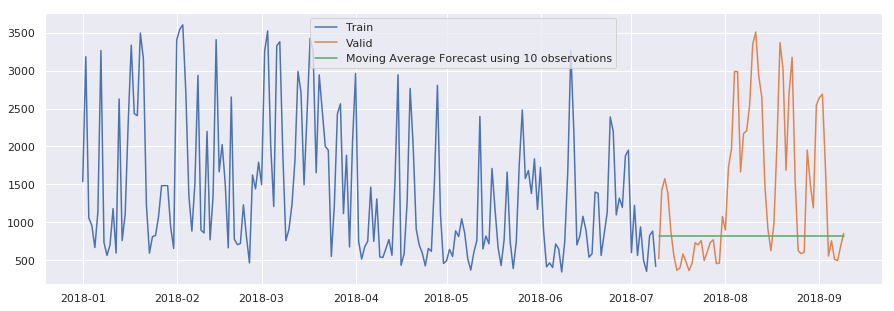

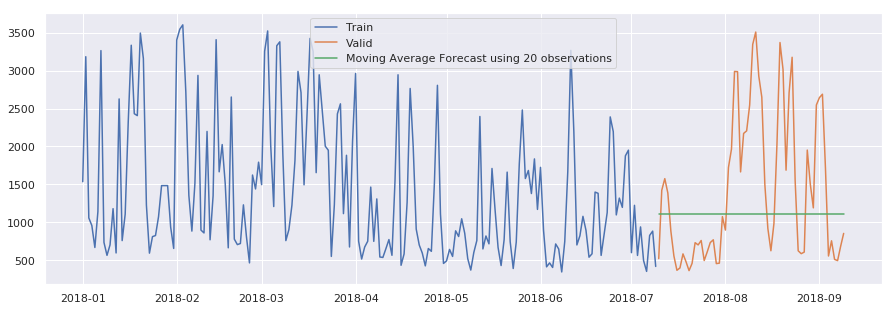

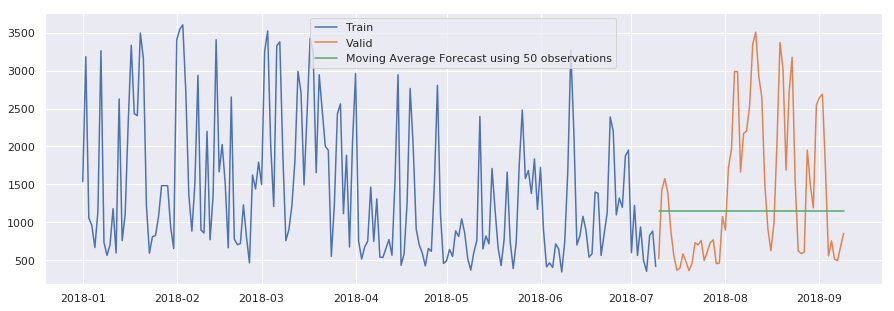

In [113]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['LV ActivePower (kW)'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['LV ActivePower (kW)'], label='Train') 
plt.plot(valid['LV ActivePower (kW)'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['LV ActivePower (kW)'].rolling(20).mean().iloc[-1] # average of last 20 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['LV ActivePower (kW)'], label='Train') 
plt.plot(valid['LV ActivePower (kW)'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['LV ActivePower (kW)'].rolling(50).mean().iloc[-1] # average of last 50 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['LV ActivePower (kW)'], label='Train') 
plt.plot(valid['LV ActivePower (kW)'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()

In [114]:
rms = sqrt(mean_squared_error(valid['LV ActivePower (kW)'], y_hat_avg.moving_avg_forecast)) 
print(rms)

997.2424283212006


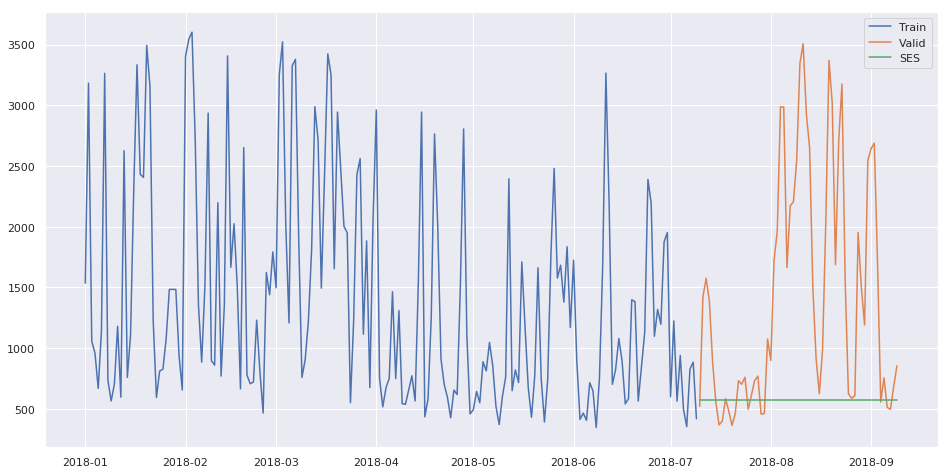

In [115]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['LV ActivePower (kW)'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['LV ActivePower (kW)'], label='Train') 
plt.plot(valid['LV ActivePower (kW)'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

In [116]:
rms = sqrt(mean_squared_error(valid['LV ActivePower (kW)'], y_hat_avg.SES)) 
print(rms)

1284.6882246882942


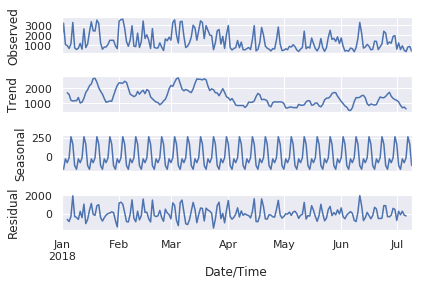

In [117]:
import statsmodels.api as sm 
sm.tsa.seasonal_decompose(Train['LV ActivePower (kW)']).plot() 
result = sm.tsa.stattools.adfuller(train['LV ActivePower (kW)']) 
plt.show()

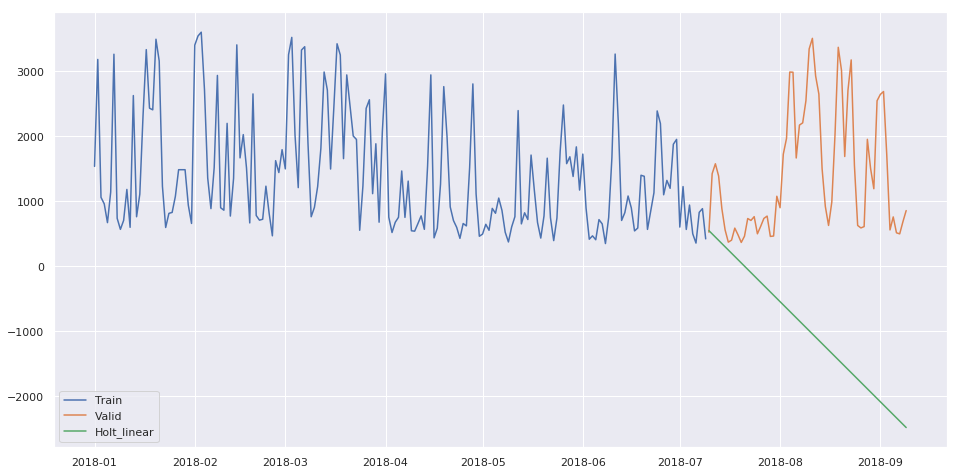

In [118]:
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train['LV ActivePower (kW)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['LV ActivePower (kW)'], label='Train') 
plt.plot(valid['LV ActivePower (kW)'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [119]:
rms = sqrt(mean_squared_error(valid['LV ActivePower (kW)'], y_hat_avg.Holt_linear)) 
print(rms)

2817.3966881437586


In [120]:
train.dtypes

LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
year                             float64
month                            float64
day                              float64
Hour                             float64
dtype: object

In [184]:
Pred=test
Pred.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),year,month,day,Hour,prediction
Date/Time,,,,,,,,,
2018-09-09,610.170577,5.979259,758.250947,52.278792,2018.0,9.0,9.0,13.161290,634.959670
2018-09-10,489.984507,5.319503,578.945818,77.164278,2018.0,9.0,10.0,11.500000,628.805268
2018-09-11,594.201770,3.981228,754.956061,149.089347,2018.0,9.0,11.0,11.500000,500.932807
2018-09-12,1167.059666,5.996219,1330.843806,45.443981,2018.0,9.0,12.0,11.500000,575.794818
2018-09-13,1850.728983,8.718563,1960.015987,93.782751,2018.0,9.0,13.0,11.447552,385.626936


In [185]:
predict=fit1.forecast(len(test))
test['prediction']=predict

In [186]:
# Calculating the hourly ratio of count
train_original['ratio']=train_original['LV ActivePower (kW)']/train_original['LV ActivePower (kW)'].sum() 

# Grouping the hourly ratio 
temp=train_original.groupby(['Hour'])['ratio'].sum() 

# Groupby to csv format 
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv') 

temp2=pd.read_csv("GROUPby.csv") 
temp2=temp2.drop('Hour.1',1) 

# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Date/Time','Hour_x','Hour_y'], axis=1) 
# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

# Converting the ratio to the original scale 
prediction['LV ActivePower (kW)']=prediction['prediction']*prediction['ratio']*72

In [187]:
Pred=prediction.drop(['day','prediction','Hour', 'ratio'],axis=1) 

In [188]:
Pred.head()

,LV ActivePower (kW)_x,Wind Speed (m/s)_x,Theoretical_Power_Curve (KWh)_x,Wind Direction (°)_x,LV ActivePower (kW)_y,Wind Speed (m/s)_y,Theoretical_Power_Curve (KWh)_y,Wind Direction (°)_y,LV ActivePower (kW)
0,610.170577,5.979259,758.250947,52.278792,757.076172,7.099374,1061.357716,76.788582,1978.058062
1,610.170577,5.979259,758.250947,52.278792,853.097412,7.442298,1228.228795,77.452583,1978.058062
2,610.170577,5.979259,758.250947,52.278792,829.076172,7.467815,1241.325856,77.109543,1978.058062
3,610.170577,5.979259,758.250947,52.278792,830.362793,7.359592,1186.449464,78.412209,1978.058062
4,610.170577,5.979259,758.250947,52.278792,746.064270,6.880200,962.958389,75.824951,2018.856407


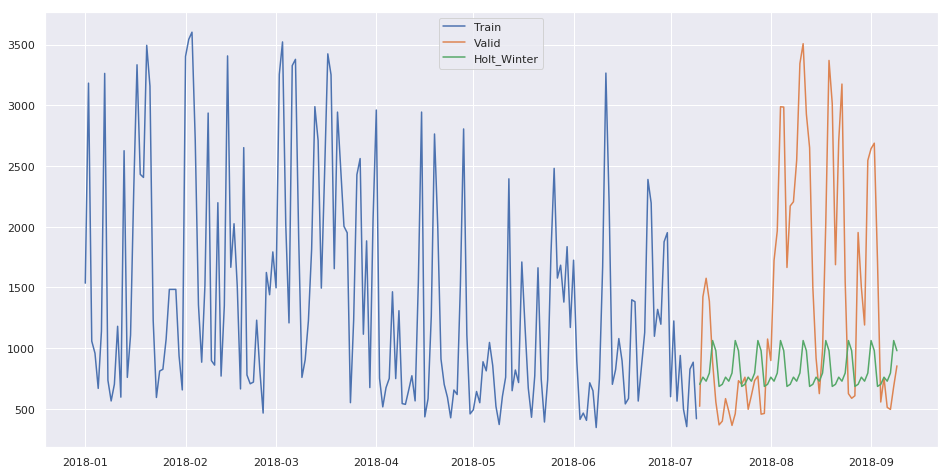

In [189]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['LV ActivePower (kW)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['LV ActivePower (kW)'], label='Train') 
plt.plot(valid['LV ActivePower (kW)'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

In [190]:
rms = sqrt(mean_squared_error(valid['LV ActivePower (kW)'], y_hat_avg.Holt_Winter)) 
print(rms)

1126.5281336328176


In [191]:
predict=fit1.forecast(len(test))

In [192]:
test['prediction']=predict
# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Date/Time','Hour_x','Hour_y'], axis=1) 

# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

# Converting the ratio to the original scale 
prediction['LV ActivePower (kW)']=prediction['prediction']*prediction['ratio']*72

In [193]:
Pred=prediction.drop(['day','Hour','ratio','prediction'],axis=1) 


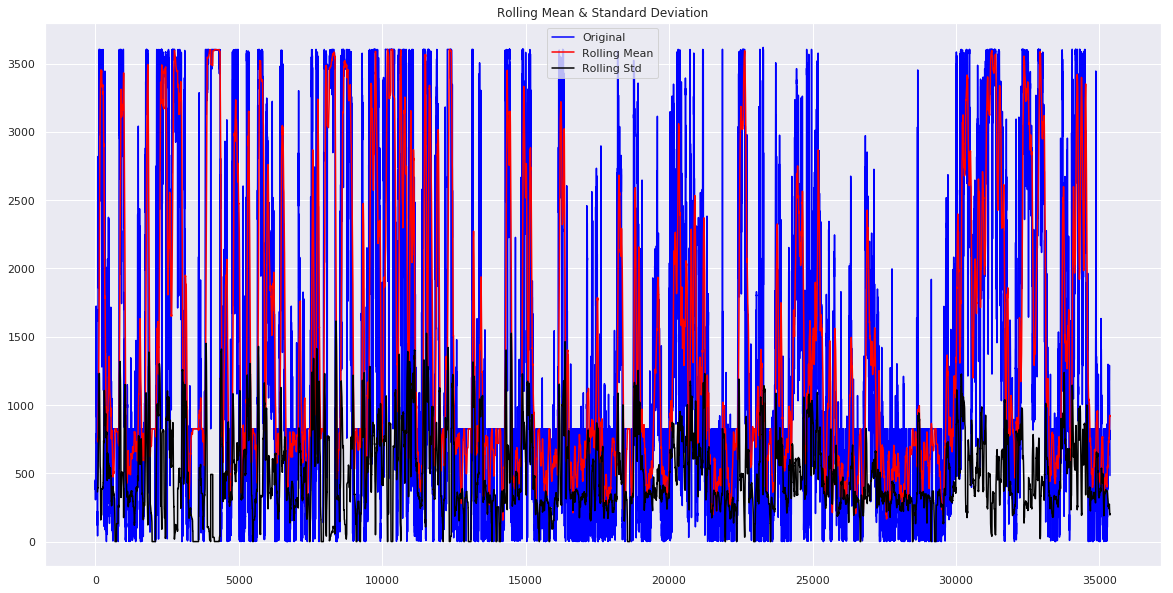

Results of Dickey-Fuller Test:
Test Statistic                -1.260997e+01
p-value                        1.663553e-23
#Lags Used                     3.100000e+01
Number of Observations Used    3.533900e+04
Critical Value (1%)           -3.430535e+00
Critical Value (5%)           -2.861622e+00
Critical Value (10%)          -2.566814e+00
dtype: float64


In [194]:
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(72).mean() # 24 hours on each day
    rolstd = timeseries.rolling(72).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['LV ActivePower (kW)'])

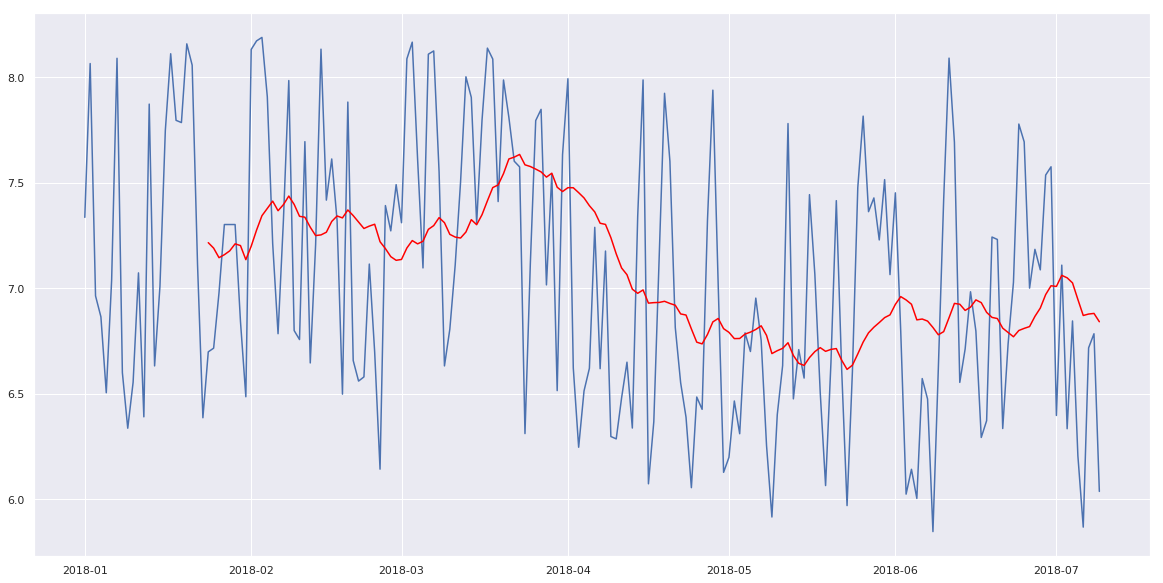

In [195]:
Train_log = np.log(Train['LV ActivePower (kW)']) 
valid_log = np.log(valid['LV ActivePower (kW)'])
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

In [196]:
train_log_moving_avg_diff = Train_log - moving_avg

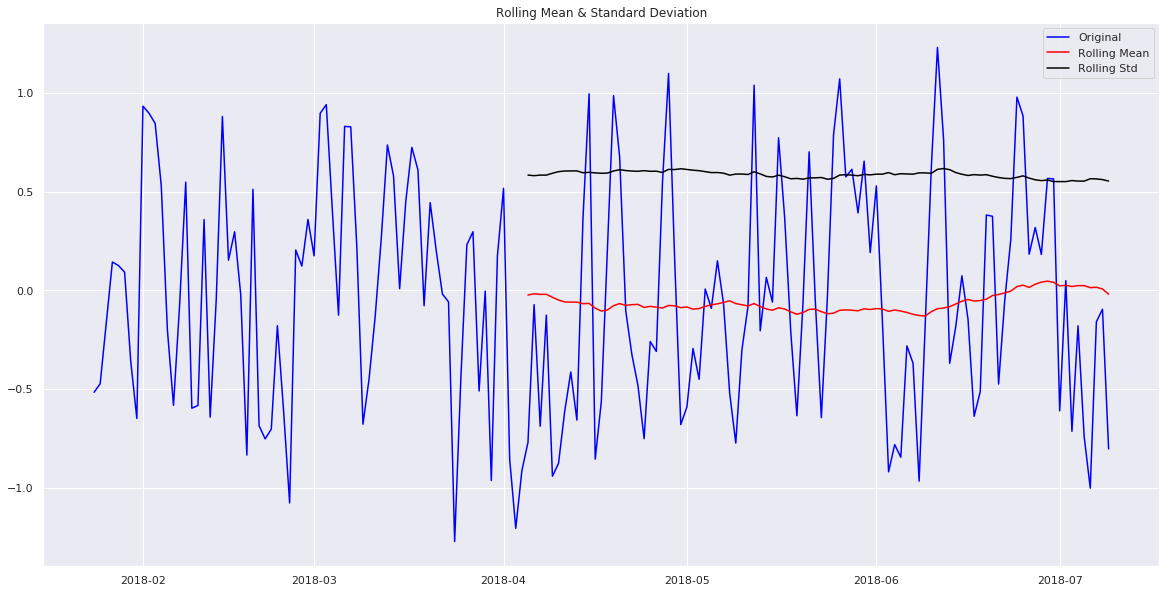

Results of Dickey-Fuller Test:
Test Statistic                -7.843155e+00
p-value                        5.863552e-12
#Lags Used                     1.000000e+00
Number of Observations Used    1.650000e+02
Critical Value (1%)           -3.470616e+00
Critical Value (5%)           -2.879221e+00
Critical Value (10%)          -2.576197e+00
dtype: float64


In [197]:
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)


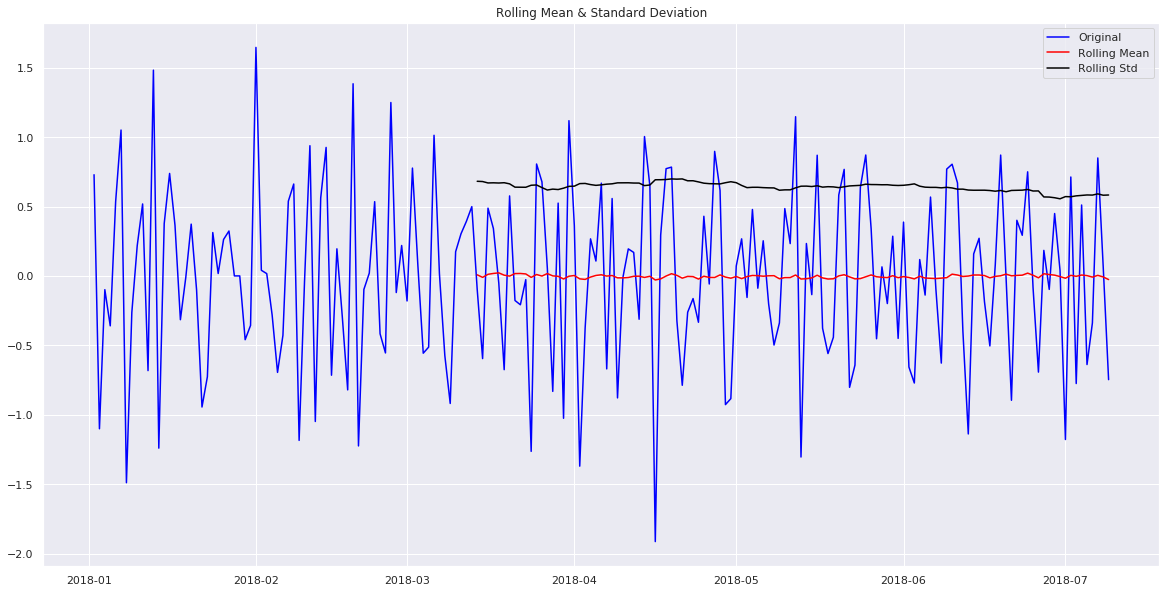

Results of Dickey-Fuller Test:
Test Statistic                -7.754445e+00
p-value                        9.822534e-12
#Lags Used                     1.200000e+01
Number of Observations Used    1.760000e+02
Critical Value (1%)           -3.468062e+00
Critical Value (5%)           -2.878106e+00
Critical Value (10%)          -2.575602e+00
dtype: float64


In [198]:
train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())


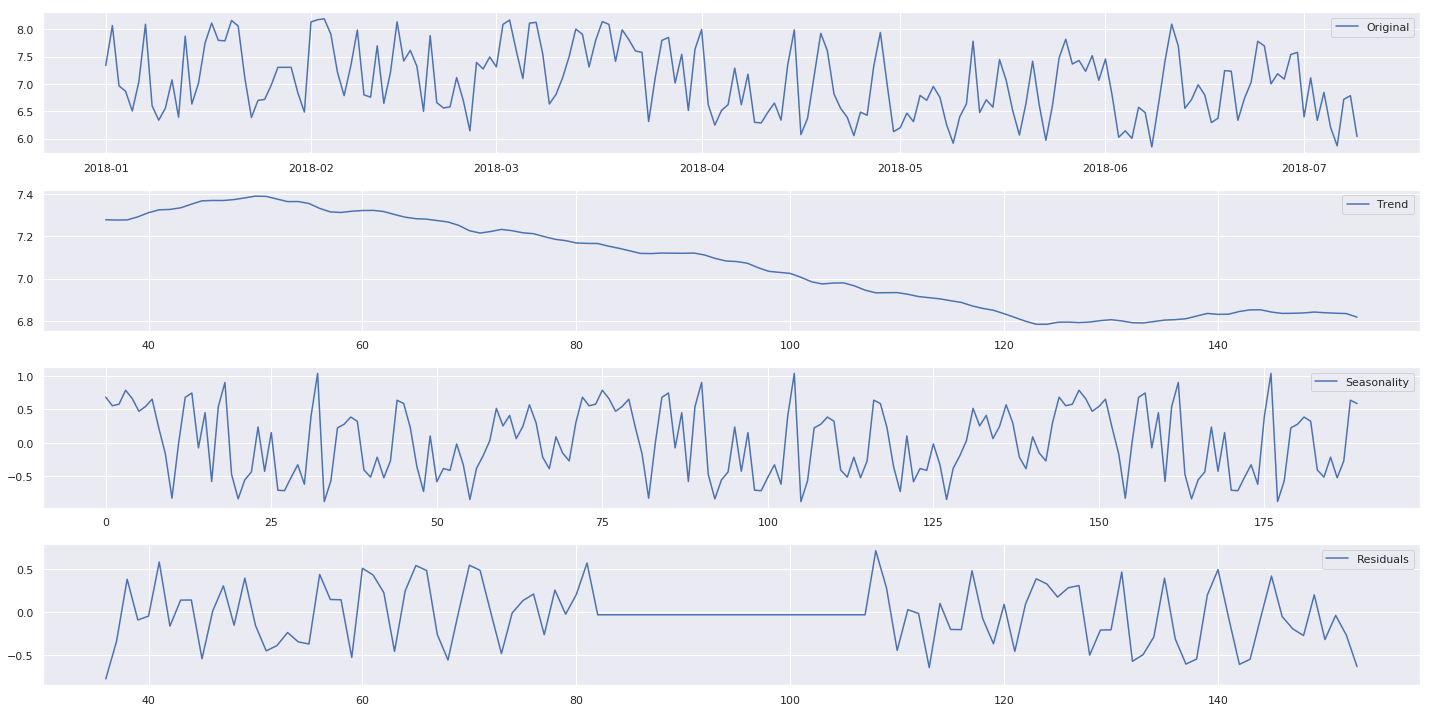

In [199]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log)['LV ActivePower (kW)'].values, freq = 72) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()


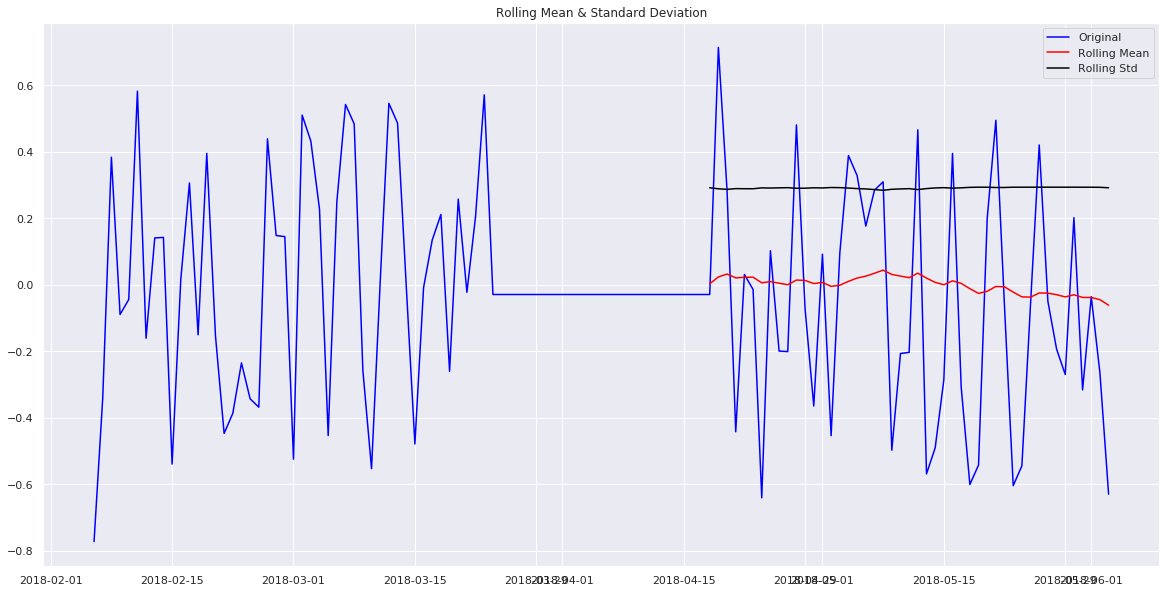

Results of Dickey-Fuller Test:
Test Statistic                  -5.530976
p-value                          0.000002
#Lags Used                       3.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


In [200]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])


In [201]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

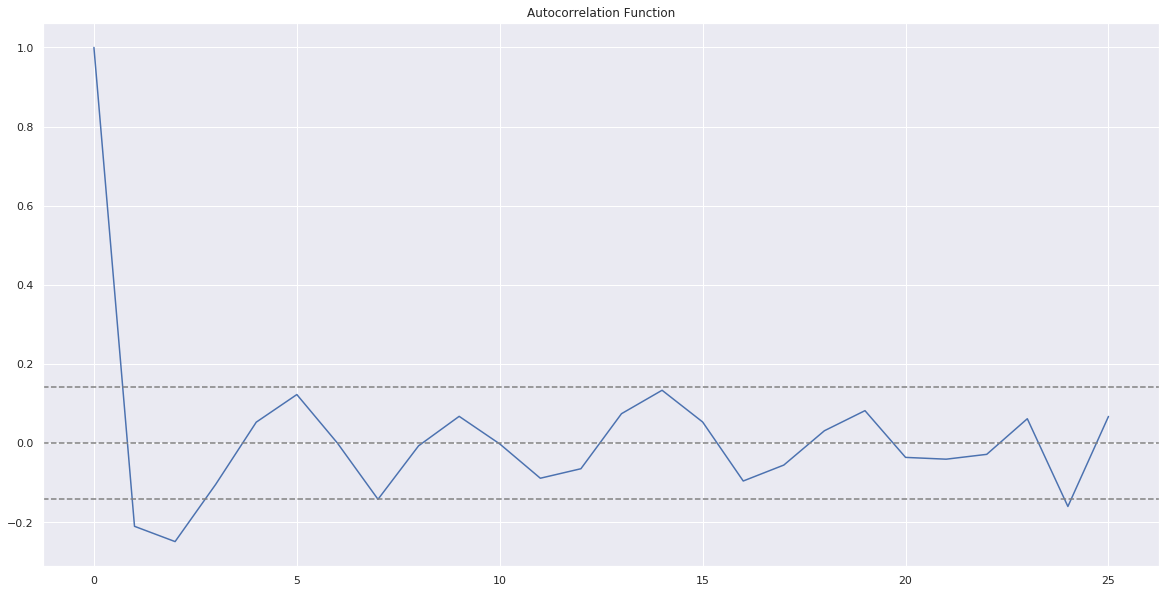

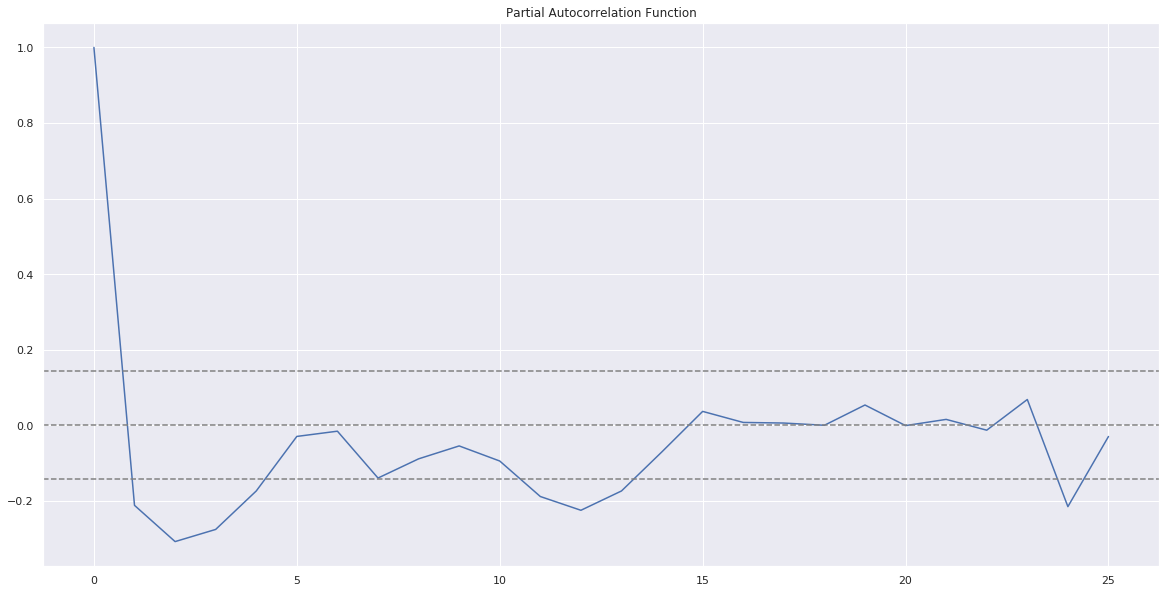

In [202]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

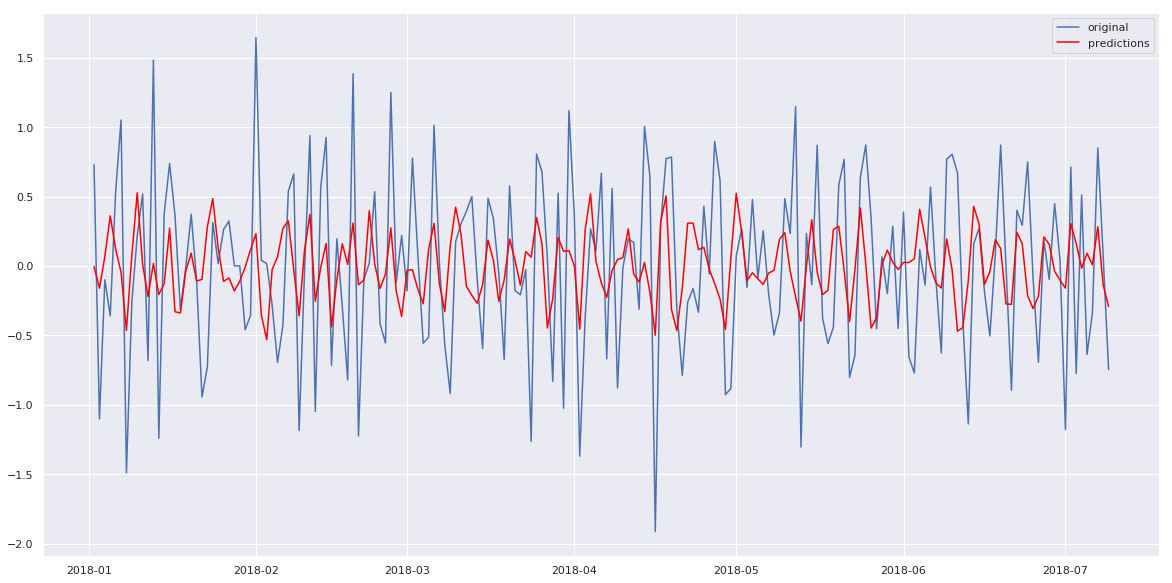

In [203]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

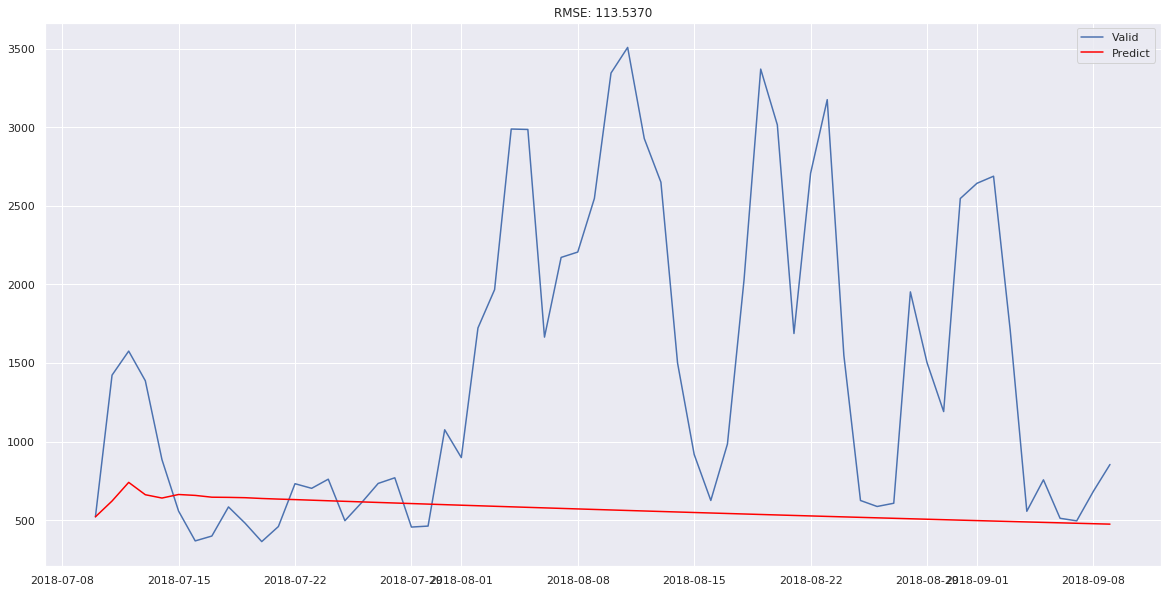

In [204]:
AR_predict=results_AR.predict(start="2018-07-10", end="2018-09-09")
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['LV ActivePower (kW)'])[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)
plt.plot(valid['LV ActivePower (kW)'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['LV ActivePower (kW)']))/valid.shape[0])) 
plt.show()

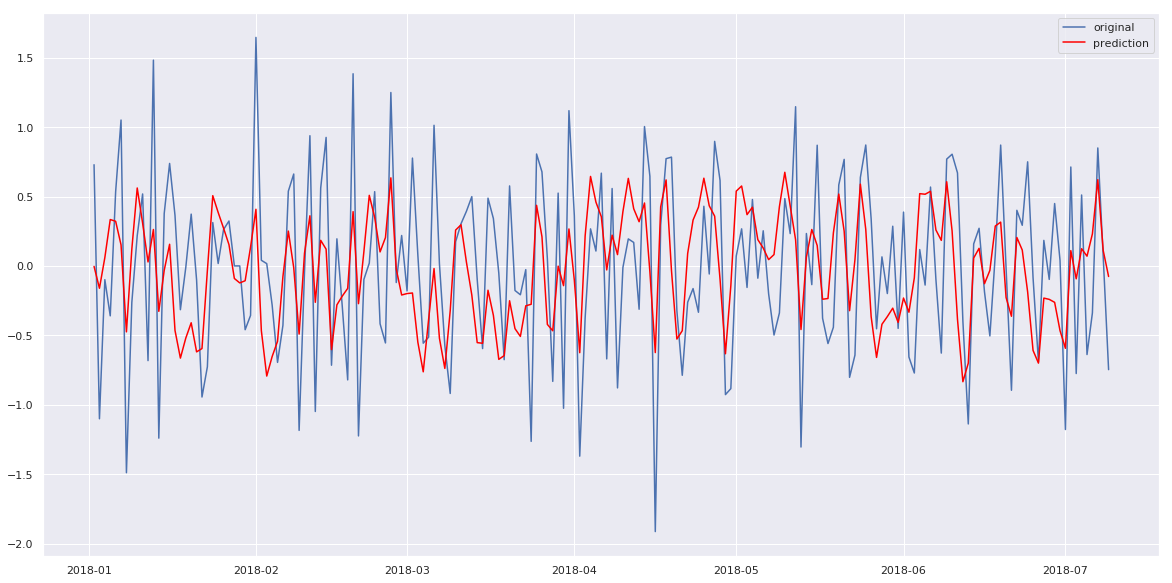

In [205]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

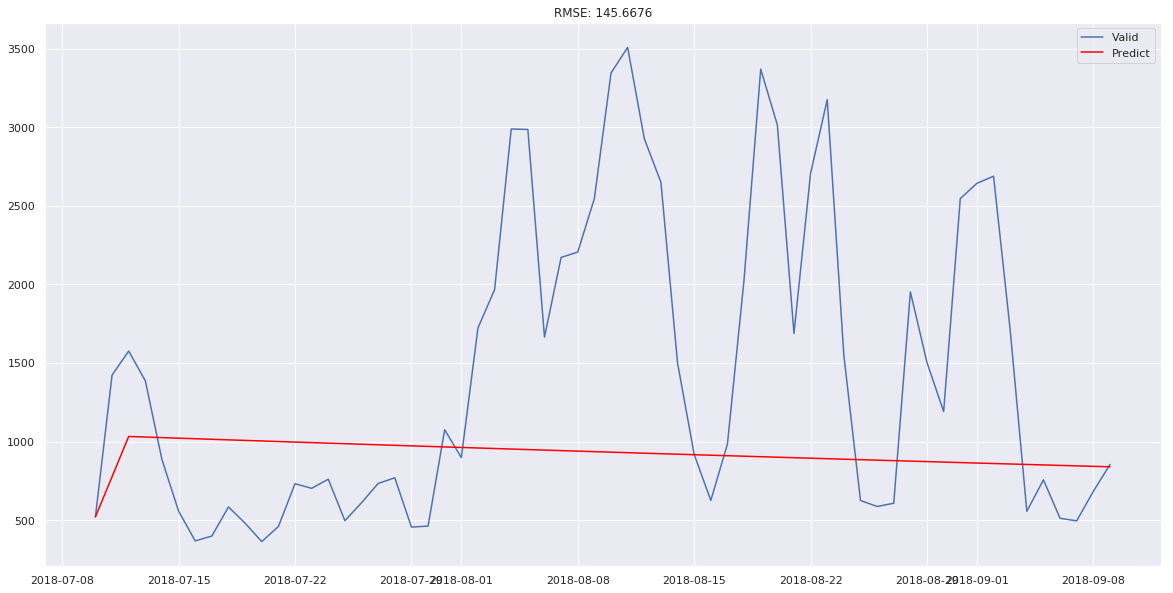

In [206]:
MA_predict=results_MA.predict(start="2018-07-10", end="2018-09-09") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['LV ActivePower (kW)'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)
plt.plot(valid['LV ActivePower (kW)'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['LV ActivePower (kW)']))/valid.shape[0]))
plt.show()

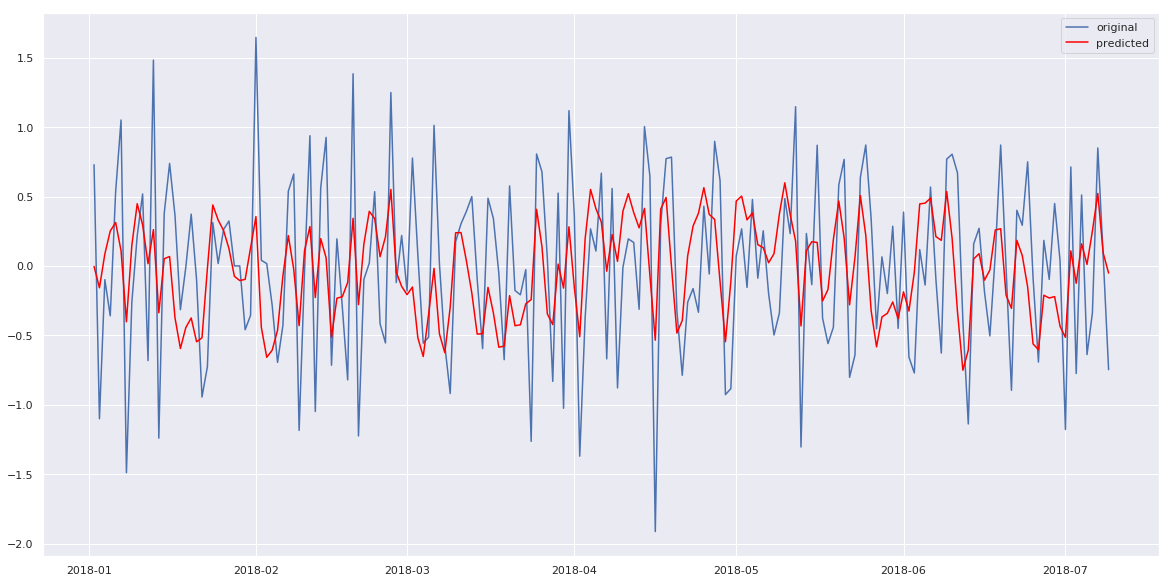

In [207]:
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

In [208]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['LV ActivePower (kW)'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['LV ActivePower (kW)'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['LV ActivePower (kW)']))/given_set.shape[0]))
    plt.show()

In [209]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['LV ActivePower (kW)'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['LV ActivePower (kW)']))/given_set.shape[0]))
    plt.show()

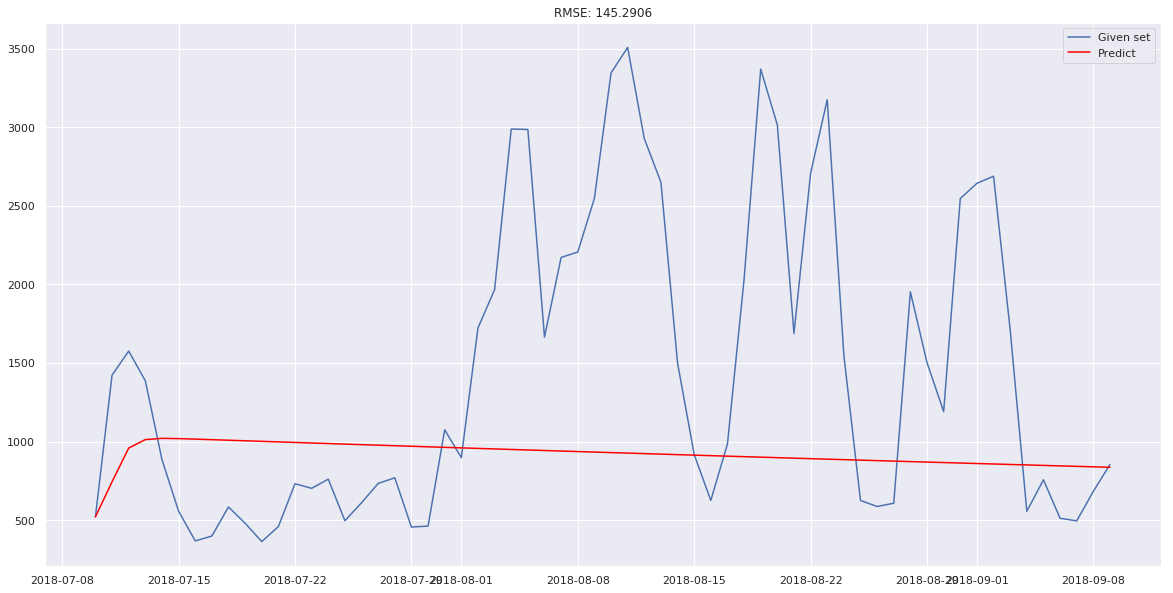

In [210]:
ARIMA_predict_diff=results_ARIMA.predict(start="2018-07-10", end="2018-09-09")
check_prediction_diff(ARIMA_predict_diff, valid)

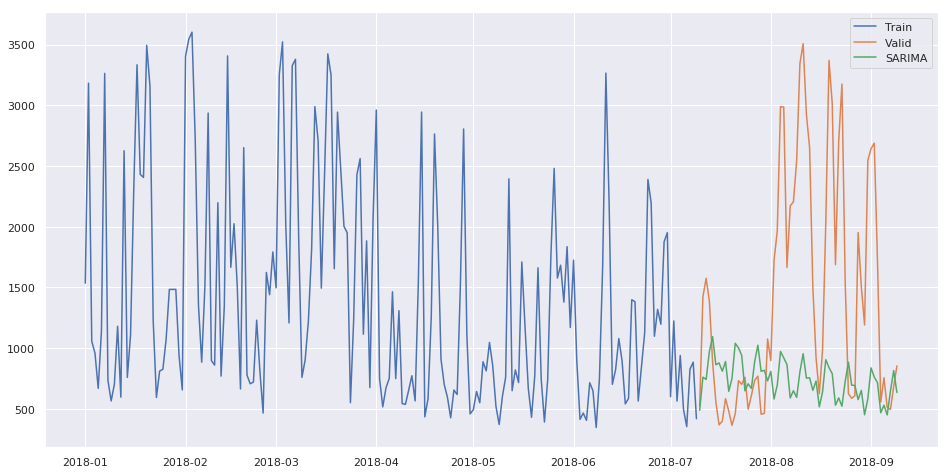

In [211]:
import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train['LV ActivePower (kW)'], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2018-07-10", end="2018-09-09", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['LV ActivePower (kW)'], label='Train') 
plt.plot(valid['LV ActivePower (kW)'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

In [212]:
rms = sqrt(mean_squared_error(valid['LV ActivePower (kW)'], y_hat_avg.SARIMA)) 
print(rms)

1186.6039791111011


In [213]:
predict=fit1.predict(start="2018-09-09", end="2018-12-31", dynamic=True)

In [214]:
test['prediction']=predict
# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Date/Time','Hour_x','Hour_y'], axis=1) 

# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

# Converting the ratio to the original scale 
prediction['LV ActivePower (kW)']=prediction['prediction']*prediction['ratio']*72

In [215]:
Pred=prediction.drop(['day','Hour','ratio','prediction'],axis=1) 


In [217]:
Result=Pred
converted=test.asfreq('4320Min',method='pad')

In [220]:

Result= pd.DataFrame(index=converted.index.copy())
Result['Prediction']=predict

In [221]:
Result.head()

,Prediction
Date/Time,
2018-09-09,634.959670
2018-09-12,575.794818
2018-09-15,769.649138
2018-09-18,405.334213
2018-09-21,570.860966
